Train models on synthetic credit card data

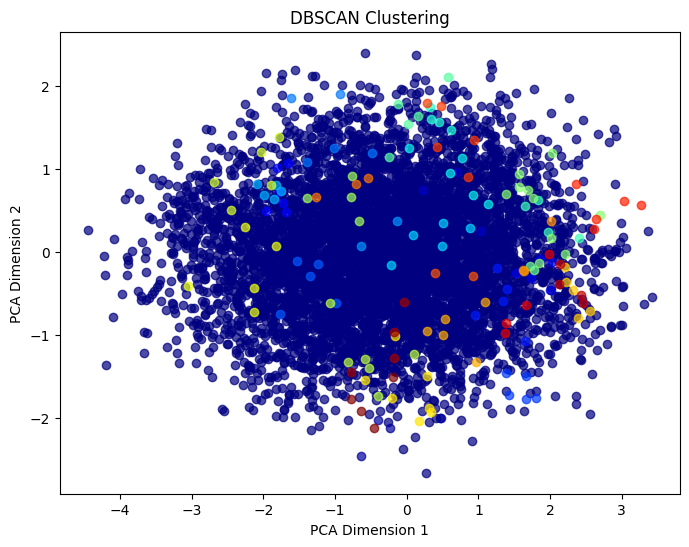

Counter({np.int64(0): 6278, np.int64(-1): 5571, np.int64(17): 10, np.int64(22): 7, np.int64(19): 6, np.int64(4): 6, np.int64(29): 5, np.int64(12): 5, np.int64(3): 5, np.int64(11): 5, np.int64(5): 5, np.int64(15): 5, np.int64(6): 5, np.int64(7): 5, np.int64(24): 5, np.int64(8): 5, np.int64(10): 5, np.int64(20): 5, np.int64(21): 5, np.int64(28): 5, np.int64(23): 5, np.int64(1): 4, np.int64(32): 4, np.int64(14): 4, np.int64(31): 4, np.int64(30): 4, np.int64(13): 4, np.int64(33): 4, np.int64(18): 4, np.int64(2): 3, np.int64(26): 3, np.int64(25): 3, np.int64(27): 2, np.int64(9): 2, np.int64(16): 2})


In [ ]:
# 1. DBSCAN to identify spending clusters/categories
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.decomposition import PCA
from collections import Counter

# Aggregate user spending data per month
data = pd.read_csv("data/synthetic_credit_card_transactions.csv")

# Split date into year and month for aggregation
data['date'] = pd.to_datetime(data['date'])
data['year_month'] = data['date'].dt.to_period('M')

# Aggregate total amount spent per user per month
monthly_spending = data.groupby(['user_id', 'year_month'])['amount'].sum().reset_index()
monthly_spending.rename(columns={'amount': 'total_spent'}, inplace=True)

# Aggregate num. transactions per user per month
num_txns = data.groupby(['user_id', 'year_month'])['amount'].count().reset_index(name='num_txns')

# Aggregate total grocery spend per user per month
filtered_data = data[data['category'] == 'Groceries']
grocery = filtered_data.groupby(['user_id', 'year_month'])['amount'].sum().reset_index(name='groceries')

# Aggregate total travel spend per user per month
filtered_data = data[data['category'] == 'Travel']
travel = filtered_data.groupby(['user_id', 'year_month'])['amount'].sum().reset_index(name='travel')

# Aggregate total shoppping spend per user per month
filtered_data = data[data['category'] == 'Shopping']
shopping = filtered_data.groupby(['user_id', 'year_month'])['amount'].sum().reset_index(name='shopping')

# Aggregate total dining spend per user per month
filtered_data = data[data['category'] == 'Dining']
dining = filtered_data.groupby(['user_id', 'year_month'])['amount'].sum().reset_index(name='dining')

# Aggregate total entertainment spend per user per month
filtered_data = data[data['category'] == 'Entertainment']
entertainment = filtered_data.groupby(['user_id', 'year_month'])['amount'].sum().reset_index(name='entertainment')

# Aggregate total personal care spend per user per month
filtered_data = data[data['category'] == 'Personal Care']
personal_care = filtered_data.groupby(['user_id', 'year_month'])['amount'].sum().reset_index(name='personal_care')

# Merge all monthly spending dataframes into one
monthly_spending = monthly_spending.merge(num_txns, on=['user_id', 'year_month'], how='left') \
    .merge(grocery, on=['user_id', 'year_month'], how='left') \
    .merge(travel, on=['user_id', 'year_month'], how='left') \
    .merge(shopping, on=['user_id', 'year_month'], how='left') \
    .merge(dining, on=['user_id', 'year_month'], how='left') \
    .merge(entertainment, on=['user_id', 'year_month'], how='left') \
    .merge(personal_care, on=['user_id', 'year_month'], how='left')

# Select features
features = ['total_spent', 'num_txns', 'groceries', 'travel', 'shopping',
            'dining', 'entertainment', 'personal_care']
X = monthly_spending[features].values

# Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=1.0, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Reduce dimensionionality for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualize DBSCAN Clusters
plt.figure(figsize=(8,6))
unique_labels = set(dbscan_labels)
colors = [plt.cm.jet(float(i) / max(unique_labels)) for i in unique_labels]
for k, col in zip(unique_labels, colors):
    if k != -1: # Noise (outliers) - don't plot
        mask = (dbscan_labels == k)
        plt.scatter(X_pca[mask, 0], X_pca[mask, 1], c=[col], alpha=0.7)

plt.title("DBSCAN Clustering")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.show()

print(Counter(dbscan_labels))